CSV Columns: ['Month', 'AustralianPort', 'ForeignPort', 'Country', 'Passengers_In', 'Freight_In_(tonnes)', 'Mail_In_(tonnes)', 'Passengers_Out', 'Freight_Out_(tonnes)', 'Mail_Out_(tonnes)', 'Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)', 'Year', 'Month_num', 'Date', 'Region']


00:26:37 - cmdstanpy - INFO - Chain [1] start processing
00:26:37 - cmdstanpy - INFO - Chain [1] done processing


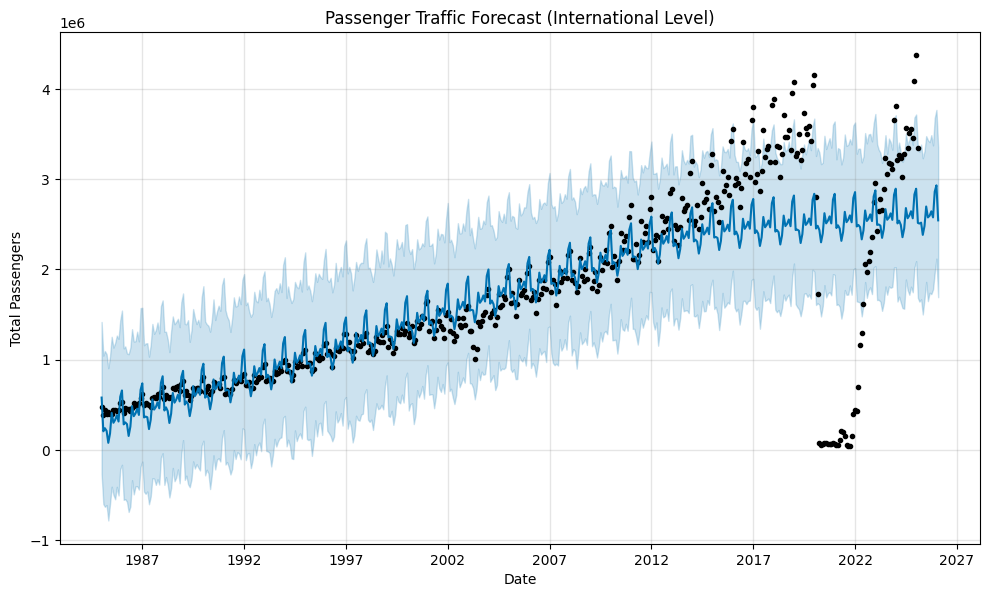

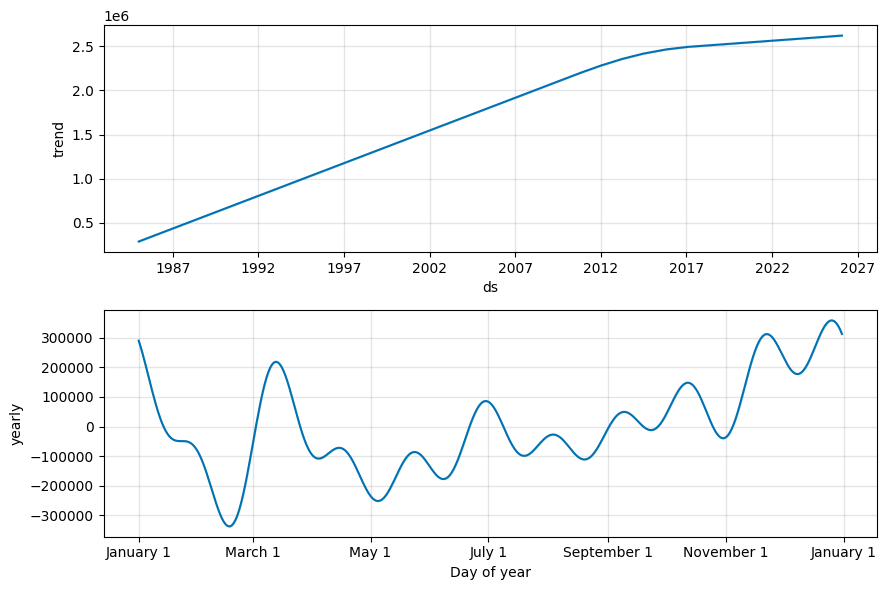

00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:38 - cmdstanpy - INFO - Chain [1] done processing


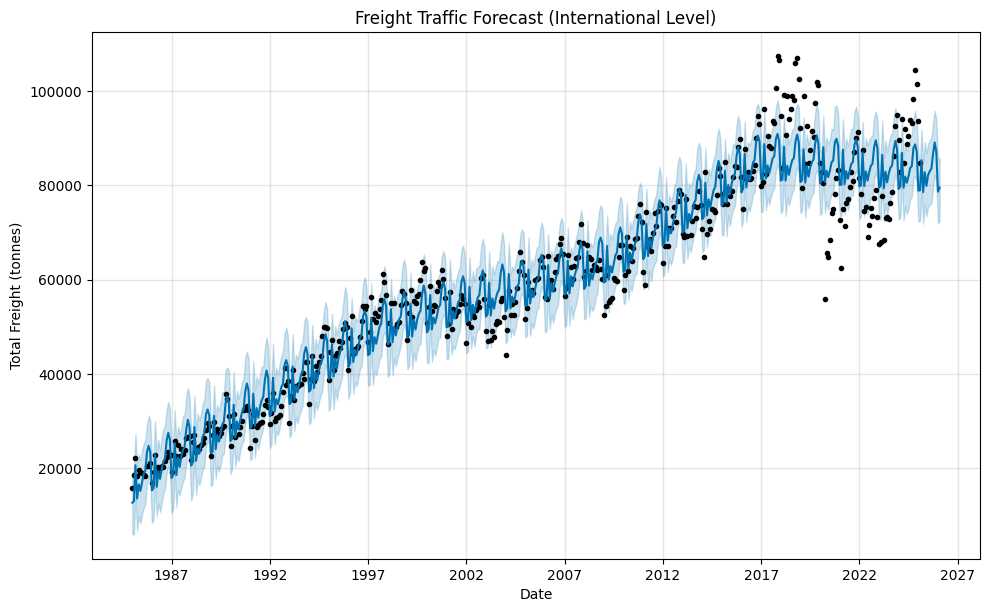

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Verify file exists
import os
if not os.path.exists('processed_city_pairs_eda.csv'):
    raise FileNotFoundError("The file 'processed_city_pairs_eda.csv' was not found in the working directory.")

# Load the processed dataset from EDA
df = pd.read_csv('processed_city_pairs_eda.csv')
print("CSV Columns:", df.columns.tolist())  # Debug: Print column names

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering
# 2.1 Aggregations by date (monthly)
monthly_agg = df.groupby('Date').agg({
    'Passengers_Total': 'sum',
    'Freight_Total_(tonnes)': 'sum',
    'Mail_Total_(tonnes)': 'sum'
}).reset_index()

# 2.2 Encoding categorical fields
try:
    from sklearn.preprocessing import LabelEncoder
    le_country = LabelEncoder()
    df['Country_Encoded'] = le_country.fit_transform(df['Country'])
    le_port = LabelEncoder()
    df['ForeignPort_Encoded'] = le_port.fit_transform(df['ForeignPort'])
    le_aus_port = LabelEncoder()
    df['AustralianPort_Encoded'] = le_aus_port.fit_transform(df['AustralianPort'])
except ImportError as e:
    print(f"Error importing LabelEncoder: {e}")
    raise

# 2.3 Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Normalized_Passengers', 'Normalized_Freight', 'Normalized_Mail']] = scaler.fit_transform(
    df[['Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)']]
)

# 3.1 Forecasting traffic volumes using time-series models
# Prepare data for Prophet (passengers)
ts_data = monthly_agg[['Date', 'Passengers_Total']].rename(columns={'Date': 'ds', 'Passengers_Total': 'y'})

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(ts_data)

# Create future dataframe for 12 months beyond August 15, 2025
future = model.make_future_dataframe(periods=12, freq='M')

# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title('Passenger Traffic Forecast (International Level)')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.show()

# Plot components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# Forecast for freight
ts_freight = monthly_agg[['Date', 'Freight_Total_(tonnes)']].rename(columns={'Date': 'ds', 'Freight_Total_(tonnes)': 'y'})
model_freight = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_freight.fit(ts_freight)
future_freight = model_freight.make_future_dataframe(periods=12, freq='M')
forecast_freight = model_freight.predict(future_freight)

fig = model_freight.plot(forecast_freight)
plt.title('Freight Traffic Forecast (International Level)')
plt.xlabel('Date')
plt.ylabel('Total Freight (tonnes)')
plt.show()

# Save forecast results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('passenger_forecast.csv', index=False)
forecast_freight[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('freight_forecast.csv', index=False)